In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ascad_tools import load_data, mean_rank
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from tqdm.notebook import tqdm

In [ ]:
def pc_grid_search(estimator, X, y, plaintexts, keys, pc, cv=5, seed=42):
    kf = KFold(n_splits=cv, shuffle=True, random_state=seed)

    for n_components in tqdm(pc):
        mean_ranks = []

        for (train_index, test_index) in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train = y[train_index]

            keys_test, ptexts_test = keys[test_index], plaintexts[test_index]

            pca = PCA(n_components=n_components, random_state=seed)
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)

            estimator.fit(X_train, y_train)
            probs = estimator.predict_proba(X_test)

            ranks = mean_rank(probs, plaintexts=ptexts_test, keys=keys_test)
            mean_ranks.append(np.mean(ranks))

        yield n_components, np.mean(mean_ranks)

X_prof, y_prof, ptexts_prof, keys_prof = load_data("data/ASCAD.h5", "Profiling")

n_components = [5, 10, 20, 50, 100]
gs = pc_grid_search(GaussianNB(), X_prof, y_prof, ptexts_prof,
                    keys_prof, n_components, cv=5)
num_pc, mean_ranks = zip(*gs)

  0%|          | 0/5 [00:00<?, ?it/s]

In [5]:
plt.plot(num_pc, mean_ranks, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Mean Rank')
plt.xticks(num_pc)
plt.grid(True)
plt.show()

NameError: name 'num_pc' is not defined

Z metody łokcia widać że GNB osiąga najlepszy $\mathrm{MeanRank}$ dla ~10 PC.

In [32]:
def run_attacks(fig, n, pc, estimator, seed=42):
    X_prof, y_prof, *_ = load_data("data/ASCAD.h5", "Profiling")
    X_atck, _, ptexts_atck, keys_atck = load_data("data/ASCAD.h5", "Attack")

    ax = fig.add_subplot(111)
    mean_ranks = []

    rng = np.random.default_rng(seed)

    for i in tqdm(range(n)):
        idx = rng.permutation(len(X_atck))
        X_atck_shuffled = X_atck[idx]

        pca = PCA(n_components=pc, random_state=i)
        X_prof_pca = pca.fit_transform(X_prof)
        X_atck_pca = pca.transform(X_atck_shuffled)

        estimator.fit(X_prof_pca, y_prof)
        probs = estimator.predict_proba(X_atck_pca)
        ranks = mean_rank(probs, ptexts_atck[idx], keys_atck[idx])

        ax.plot(ranks, alpha=0.3)
        mean_ranks.append(ranks)

    ax.set_xlabel('Number of Traces')
    ax.set_ylabel('Rank of the Correct Key')

    mean_ranks = np.mean(mean_ranks, axis=0)
    ax.plot(mean_ranks, color='black', label='Mean Ranks', linewidth=2)

    mean_rank_val = np.mean(mean_ranks)
    ax.axhline(y=mean_rank_val, color='r', linestyle='--',
                label=f'Mean Rank ({mean_rank_val:.2f})')
    ax.grid(True)
    ax.legend()
    return estimator

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 0.98, 'GaussianNB')

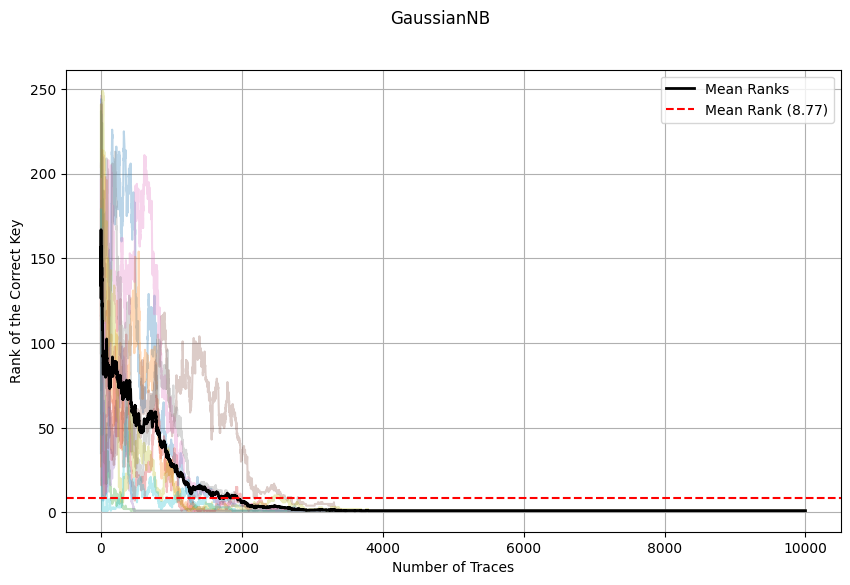

In [35]:
fig = plt.figure(figsize=(10, 6))
gnb = run_attacks(fig, n=10, pc=10, estimator=GaussianNB())
fig.suptitle("GaussianNB")

Moim pierwszym typem był naiwny klasyfikator bayesowski - jest szybki i dobrze pasuje do danych. Problemem może okazać się nieliniowa korelacja pomiędzy cechami.

  0%|          | 0/10 [00:00<?, ?it/s]

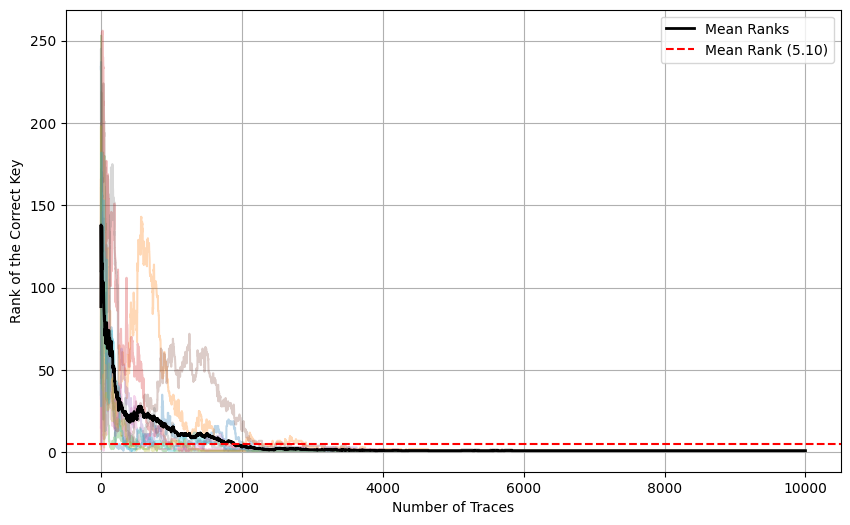

In [ ]:
from sklearn.tree import DecisionTreeClassifier

fig = plt.figure(figsize=(10, 6))
run_attacks(
    fig, n=10, pc=10,
    estimator=DecisionTreeClassifier(max_depth=10, random_state=42)
)
fig.suptitle('DT (max_depth=10)')

Drugim modelem wartym przetestowania wydały mi się drzewa decyzyjne - mogą lepiej modelować zależności pomiędzy próbkami. Łatwo overfitują do danych, ale jak na prostotę tego modelu wyniki wydały mi się zaskakująco dobre.

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 0.98, 'RF (n_est=50, depth=10, max_feat=sqrt)')

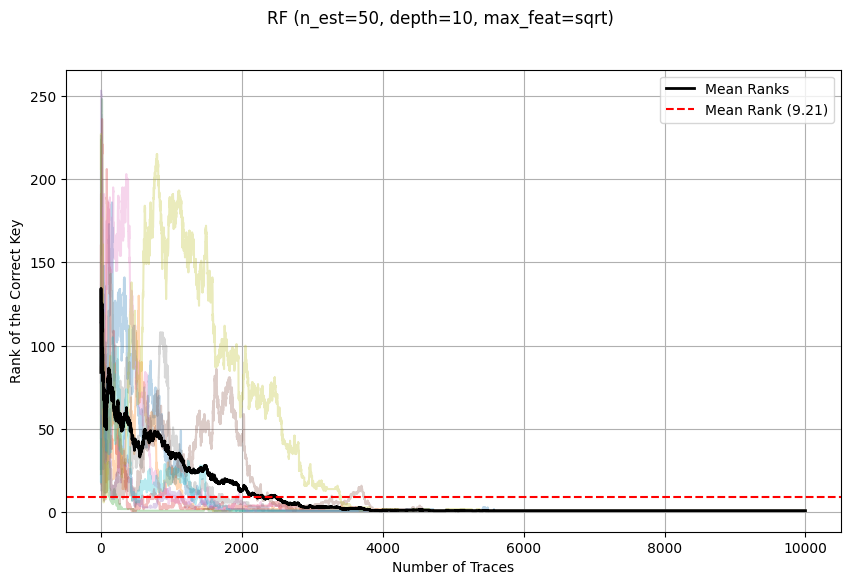

In [24]:
from sklearn.ensemble import RandomForestClassifier

fig = plt.figure(figsize=(10, 6))
run_attacks(
    fig, n=10, pc=10,
    estimator=RandomForestClassifier(
        n_estimators=50, max_depth=10, max_features='sqrt',
        random_state=42, n_jobs=-1
    )
)
fig.suptitle('RF (n_est=50, depth=10, max_feat=sqrt)')

Okazuje się, że las losowy radzi sobie gorzej, przy max_features=n_features występuje overconfidence, a przy max_features=sqrt underfitting.

  0%|          | 0/5 [00:00<?, ?it/s]

Text(0.5, 0.98, 'XGBoost (n_est=50, depth=5, feat=0.8)')

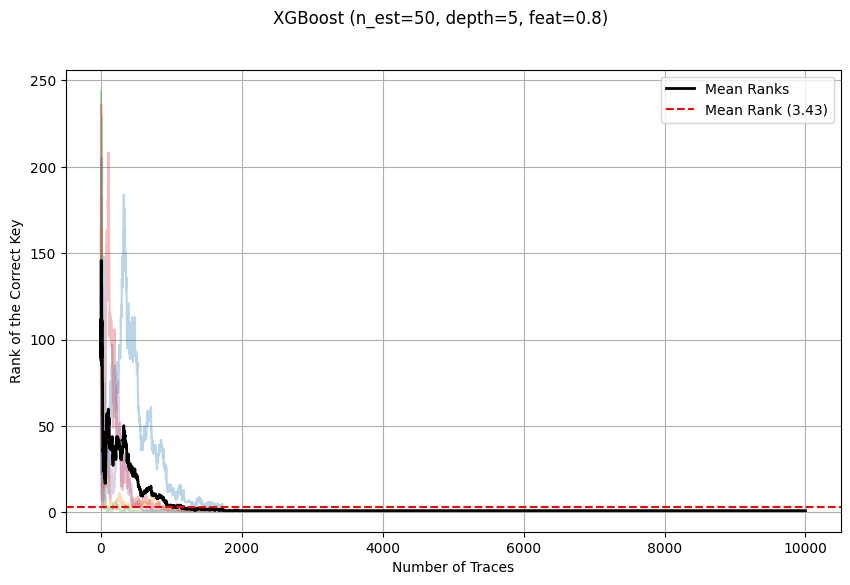

In [30]:
from xgboost import XGBClassifier

fig = plt.figure(figsize=(10, 6))
run_attacks(
    fig, n=5, pc=10,
    estimator=XGBClassifier(
        n_estimators=50,
        max_depth=5,
        learning_rate=0.1,
        colsample_bytree=0.8,
        subsample=0.8,
        random_state=42,
        n_jobs=-1,
    ),
)
fig.suptitle('XGBoost (n_est=50, depth=5, feat=0.8)')

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 0.98, 'QDA')

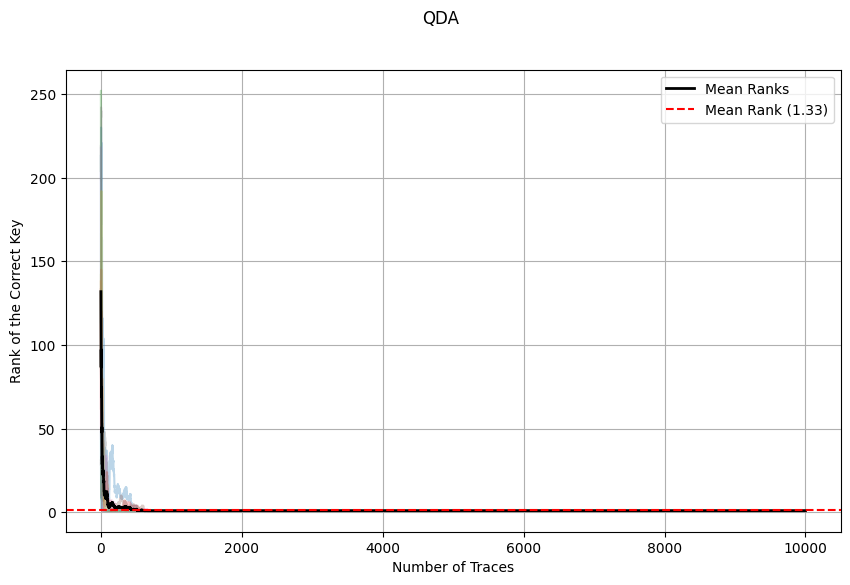

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

fig = plt.figure(figsize=(10, 6))
run_attacks(fig, n=10, pc=10, estimator=QDA())
fig.suptitle('QDA')